In [1]:
# part 2 experimentation: Evaluate and fine-tune the pretrained model on darker cloudy dataset
# major library dependencies: jupyter, numpy, matplotlib, pytorch, scikit-image, pillow

import torch
from dataset import camvidLoader
import numpy as np
from unet import UNet
import matplotlib.pyplot as plt
from skimage.io import imsave
import os
from torch.utils.data import Dataset, DataLoader
import data_aug as aug
from tempfile import TemporaryDirectory
import warnings
warnings.filterwarnings("ignore")

device = 'cpu' # can be set to "cuda" if you have a GPU
unet = torch.load('camvid_sunny_model.pt', map_location=torch.device(device))

data_root = './CamVid/cloudy'
test_data = camvidLoader(root=data_root, split='test', is_aug=False, img_size = [256, 256], is_pytorch_transform=True)

num_classes = 14 # number of classes is always 14 for this project.
labels = ['Sky', 'Building', 'Pole', 'Road', 'LaneMarking', 'SideWalk', 'Pavement', 'Tree', 'SignSymbol', 
          'Fence', 'Car_Bus', 'Pedestrian', 'Bicyclist', 'Others']

In [2]:
# define hyper parameters
lr = 0.0002
epochs = 30
batch_size = 5
num_workers = 8

# import pre-trained model
unet_model = UNet(3, num_classes, width=32, bilinear=True)
unet = torch.load('camvid_sunny_model.pt', map_location=torch.device(device))
unet_model.load_state_dict(unet.state_dict())
unet_model = unet_model.to(device)

# import test dataset
test_loader = DataLoader(test_data, num_workers=num_workers, batch_size=batch_size, shuffle=False, drop_last=False)


## evaluate pre-trained model performance on cloudy dataset

In [3]:
# evaluation metric of accuracy.
def global_accuracy_metric(y_true, y_pred):
    return np.sum(y_true == y_pred)/y_pred.size

# evaluation metric of iou.
def IoU_metric(y_true, y_pred):

    iou_per_image = []
    
    for i in range(num_classes):
        intersection = np.logical_and(y_pred == i, y_true == i).sum()
        union = np.logical_or(y_pred == i, y_true == i).sum()
        
        # if the union is 0, then the iou should be null
        # otherwise, the iou is intersection/union
        if union == 0:
            iou = np.NAN
        else:
            iou = intersection/union
            
        iou_per_image.append(iou)

    return iou_per_image

In [5]:
global_acc = []
perclass_acc = []
img_file = []

# start evaluation
unet_model.eval()

for idx_batch, (imagergb, labelmask, filename) in enumerate(test_loader):

    img_file.extend(filename)
    
    with torch.no_grad(): 

        x = imagergb.to(device) 
        y_ = labelmask.to(device) 
        y = unet_model(x)

        for idx in range(0, y.shape[0]):

            # choose the most likely label
            max_index = torch.argmax(y[idx], dim=0).cpu().int().numpy()
            gt_correct_format = y_[idx].cpu().int().numpy()

            # calculate the global accuracy of each image
            correct_prediction = global_accuracy_metric(gt_correct_format, max_index)
            global_acc.append(correct_prediction)

            # calculate the iou per class of each image
            iou_per_image = IoU_metric(gt_correct_format, max_index)
            perclass_acc.append(iou_per_image)

In [6]:
# print and calculate the global image accuracy 
print(f'The global accuracy overall image is: {np.mean(global_acc)}')

# print and calculate the average mIOU
overall_class_iou = np.nanmean(perclass_acc, axis=0)
print(f'The average mIoU scores is: {np.nanmean(overall_class_iou)}\n')

# print and calculate the IOU per class
for idx in range(num_classes):
    print(f'The overall IOU scores for class {labels[idx]} is {overall_class_iou[idx]}')

The global accuracy overall image is: 0.6261545817057291
The average mIoU scores is: 0.2486438992912801

The overall IOU scores for class Sky is 0.7449621432692323
The overall IOU scores for class Building is 0.35695744396169377
The overall IOU scores for class Pole is 0.0
The overall IOU scores for class Road is 0.6171686458794531
The overall IOU scores for class LaneMarking is 0.04275855186359421
The overall IOU scores for class SideWalk is 0.4723643360598028
The overall IOU scores for class Pavement is nan
The overall IOU scores for class Tree is 0.5532176403814405
The overall IOU scores for class SignSymbol is 0.0
The overall IOU scores for class Fence is 0.0
The overall IOU scores for class Car_Bus is 0.3341598924433266
The overall IOU scores for class Pedestrian is 0.11071515016093807
The overall IOU scores for class Bicyclist is 0.0
The overall IOU scores for class Others is 6.688676716070037e-05


## start fine-tune

In [7]:
# import train and validation dataset
aug_obj = aug.Compose([aug.RandomHorizontalFlip(), aug.RandomResizedCrop(256),
                   aug.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4)])

train_dataset = camvidLoader(root=data_root, split='train', is_aug=True, img_size = [256, 256], 
                             is_pytorch_transform = True, aug = aug_obj) 
train_loader = DataLoader(train_dataset, num_workers=num_workers, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = camvidLoader(root=data_root, split='val', is_aug=False, img_size = [256, 256], 
                             is_pytorch_transform = True, aug = None) 
val_loader = DataLoader(val_dataset, num_workers=num_workers, batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
# create a file to store checkpoint model parameters
model_dir = './model_dir/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

def fine_tuning(model, loss_func, optimizer):

    with TemporaryDirectory() as tempdir:

        # the path to store the best parameters
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_loss = float('Inf')

        # store train and validation loss each epoch
        train_loss_list = []
        val_loss_list = []

    
        for epoch in range(epochs):

            # start trainning loop
            model.train()
            train_loss = 0
            count = 0

            for idx_batch, (imagergb, labelmask, filename) in enumerate(train_loader):

                # zero the grad of the network before feed-forward
                optimizer.zero_grad()

                # send to the device (GPU or CPU) and do a forward pass
                x = imagergb.to(device)
                y_ = labelmask.to(device)
                y = model(x)

                # finally calculate the loss and back propagate
                loss = loss_func(y, y_)
                loss.backward()
                optimizer.step()

                if idx_batch % 3 == 0:
                    print("train epoch = " + str(epoch) + " | batch = " + str(idx_batch) + " | loss = "+str(loss.item()))
                train_loss += loss.item()
                count += 1
            
            # calculate average train loss each epoch
            epoch_train_loss = train_loss/count
            train_loss_list.append(epoch_train_loss)

            # start evaluation
            model.eval()
            val_loss = 0
            count = 0

            for idx_batch, (imagergb, labelmask, filename) in enumerate(val_loader):

                with torch.no_grad(): 
                    x = imagergb.to(device)
                    y_ = labelmask.to(device)
                    y = model(x)
                    loss = loss_func(y, y_)
                    val_loss += loss.item()
                    count += 1

            # calculate average validaiotn loss each epoch
            epoch_val_loss = val_loss/count
            val_loss_list.append(epoch_val_loss)

            # store the best parameters when the loss is mininal
            if epoch_val_loss < best_loss:
                best_loss = epoch_val_loss
                torch.save(model.state_dict(), best_model_params_path)

            print(f'In epoch {epoch}, the train loss is: {epoch_train_loss}, the val loss is: {epoch_val_loss}')

            # store the check point parameters into dir
            model_location = model_dir + "model_file_epoch_" + str(epoch) + ".pt"
            torch.save(model, model_location)

        # import the best parameters to unet model
        model.load_state_dict(torch.load(best_model_params_path))

    return model, train_loss_list, val_loss_list

In [9]:
# define loss and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=lr)

# start fine-tune the model
model, train_loss, val_loss = fine_tuning(unet_model, loss_func, optimizer)

train epoch = 0 | batch = 0 | loss = 1.550964117050171
train epoch = 0 | batch = 3 | loss = 0.864214301109314
train epoch = 0 | batch = 6 | loss = 0.7805601954460144
train epoch = 0 | batch = 9 | loss = 0.9428280591964722
train epoch = 0 | batch = 12 | loss = 0.7348657250404358
In epoch 0, the train loss is: 0.9070294541972024, the val loss is: 0.9692324995994568
train epoch = 1 | batch = 0 | loss = 0.6571624875068665
train epoch = 1 | batch = 3 | loss = 0.5421954393386841
train epoch = 1 | batch = 6 | loss = 0.8711856007575989
train epoch = 1 | batch = 9 | loss = 0.7597930431365967
train epoch = 1 | batch = 12 | loss = 0.6296339631080627
In epoch 1, the train loss is: 0.7353711639131818, the val loss is: 0.8109205067157745
train epoch = 2 | batch = 0 | loss = 0.737324595451355
train epoch = 2 | batch = 3 | loss = 0.6285761594772339
train epoch = 2 | batch = 6 | loss = 0.9894908666610718
train epoch = 2 | batch = 9 | loss = 1.0683753490447998
train epoch = 2 | batch = 12 | loss = 0.686

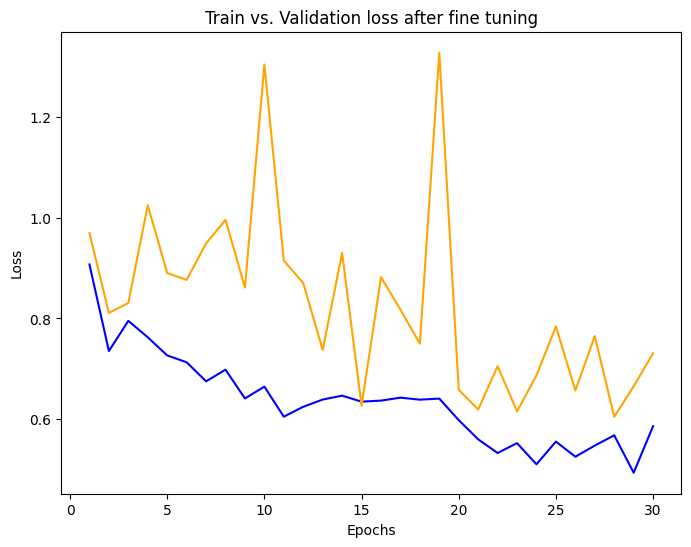

In [10]:
# plot the train and validation loss curve

epoch_list = range(1,31)

plt.figure(figsize=(8,6))
plt.plot(epoch_list, train_loss, color='blue')
plt.plot(epoch_list, val_loss, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs. Validation loss after fine tuning')
plt.show()

## evaluate the model performace after fine-tune

In [11]:
global_acc = []
perclass_acc = []
img_file = []

# start evaluation
model.eval()

for idx_batch, (imagergb, labelmask, filename) in enumerate(test_loader):

    img_file.extend(filename)
    
    with torch.no_grad(): 

        x = imagergb.to(device) 
        y_ = labelmask.to(device) 
        y = model(x)

        for idx in range(0, y.shape[0]):

            # choose the most likely label
            max_index = torch.argmax(y[idx], dim=0).cpu().int().numpy()
            gt_correct_format = y_[idx].cpu().int().numpy()

            # calculate the global accuracy of each image
            correct_prediction = global_accuracy_metric(gt_correct_format, max_index)
            global_acc.append(correct_prediction)

            # calculate the iou per class of each image
            iou_per_image = IoU_metric(gt_correct_format, max_index)
            perclass_acc.append(iou_per_image)

In [12]:
# print and calculate the global image accuracy 
print(f'The global accuracy overall image is: {np.mean(global_acc)}')

# print and calculate the average mIOU
overall_class_iou = np.nanmean(perclass_acc, axis=0)
print(f'The average mIoU scores is: {np.nanmean(overall_class_iou)}\n')

# print and calculate the IOU per class
for idx in range(num_classes):
    print(f'The overall IOU scores for class {labels[idx]} is {overall_class_iou[idx]}')

The global accuracy overall image is: 0.8012650807698568
The average mIoU scores is: 0.39824561812907255

The overall IOU scores for class Sky is 0.895168938207771
The overall IOU scores for class Building is 0.5371232108978359
The overall IOU scores for class Pole is 0.0
The overall IOU scores for class Road is 0.7174874163485431
The overall IOU scores for class LaneMarking is 0.15946398543737825
The overall IOU scores for class SideWalk is 0.7376489542270548
The overall IOU scores for class Pavement is nan
The overall IOU scores for class Tree is 0.6899640494641591
The overall IOU scores for class SignSymbol is 0.0
The overall IOU scores for class Fence is 0.0
The overall IOU scores for class Car_Bus is 0.6485936662547103
The overall IOU scores for class Pedestrian is 0.3843226886909265
The overall IOU scores for class Bicyclist is 0.0
The overall IOU scores for class Others is 0.40742012614956424
